# Introduction

*something about pid controller...*

# Task

It is necessary to select the coefficients for the PID controller. Usually this task is solved manually by going through all possible parameters. Let's try to automate this process using a genetic algorithm. Below is an example of how a PID controller for a temperature sensor works. For more realism in this simulation, the temperature of this sensor will change over time. (Let's take three different intervals within which the temperature will be fixed)

In a real task, similar actions could be performed. Thus, the genetic algorithm will select the most optimal parameters of the regulator for the best operation of the temperature sensor.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
sns.set_theme()

START_VALUE = 10.

SETPOINT_1 = 30.
TIME_INTERVAL_1 = 5.

SETPOINT_2 = 20.
TIME_INTERVAL_2 = 5.

SETPOINT_3 = 40.
TIME_INTERVAL_3 = 5.

MAX_TIME  = TIME_INTERVAL_1 + TIME_INTERVAL_2 + TIME_INTERVAL_3
TIME_STEP = 0.1


class PIDController:
    def __init__(self, P_coef, I_coef, D_coef):
        self.P_coef = P_coef
        self.I_coef = I_coef
        self.D_coef = D_coef
        self.last_error = 0
        self.integral = 0

    def calculate(self, setpoint, feedback):
        error = setpoint - feedback
        self.integral += error * TIME_STEP
        derivative = (error - self.last_error) / TIME_STEP
        output = (self.P_coef * error) + (self.I_coef * self.integral) + (self.D_coef * derivative)
        self.last_error = error
        return output


# let's take the coefficients equal to 1, 0.5, 0.001 (at random)
pid = PIDController(P_coef=1., I_coef=0.5, D_coef=0.01)
setpoint = SETPOINT_1  # we want to move on this position
feedback = START_VALUE # start position

t_arr        = []
setpoint_arr = []
feedback_arr = []
output_arr   = []
rmse_arr     = []

start_time = time.time()
error_squared_sum = 0
num_iterations = 0
current_time = 0

while current_time < MAX_TIME:
    
    if current_time > (TIME_INTERVAL_1 + TIME_INTERVAL_2):
        setpoint = SETPOINT_3
    elif current_time > TIME_INTERVAL_1:
        setpoint = SETPOINT_2
    
    output = pid.calculate(setpoint, feedback)
    
    feedback += output

    error = (setpoint - feedback)
    error_squared_sum += error ** 2
    
    num_iterations += 1

    # fill array to build plots:
    t_arr.append(current_time) 
    setpoint_arr.append(setpoint)
    feedback_arr.append(feedback)
    output_arr.append(output)
    rmse_arr.append(np.sqrt(error_squared_sum / num_iterations))

    time.sleep(TIME_STEP) # delay to simulate real time
    current_time = time.time() - start_time

We visualize the results of our simulation by plotting the appropriate plots:

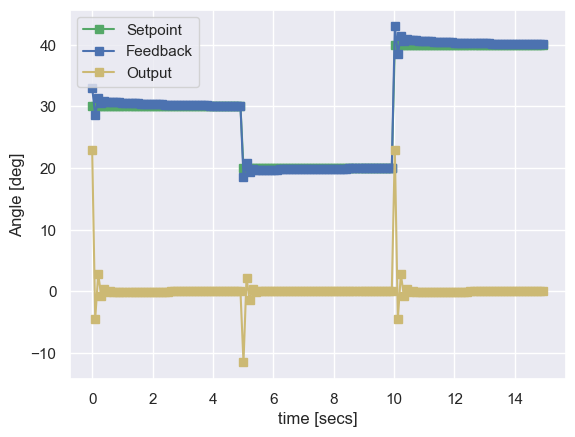

In [2]:
plt.figure()
plt.plot(t_arr, setpoint_arr, color='g', marker='s', label='Setpoint')
plt.plot(t_arr, feedback_arr, color='b', marker='s', label='Feedback')
plt.plot(t_arr, output_arr,   color='y', marker='s', label='Output')
plt.ylabel("Temperature [℃]")
plt.xlabel("Time [secs]")
plt.legend()
plt.show()

It is the final value of the root mean square error function that we will optimize using a genetic algorithm (We will look for its minimum). Let's display her current plot:

Final RMSE: 0.5436181056511009


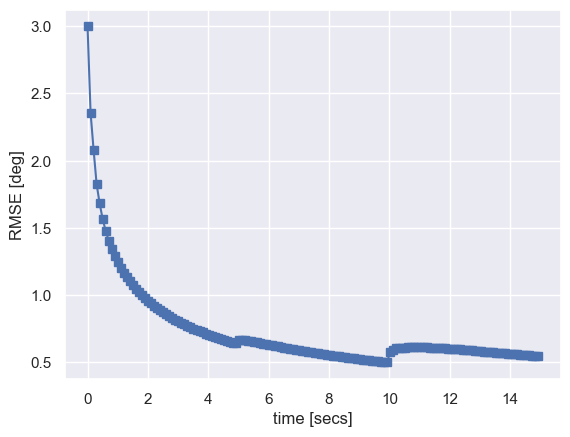

In [3]:
print("Final RMSE: {RMSE}".format(RMSE=rmse_arr[-1]))
plt.figure()
plt.plot(t_arr, rmse_arr, color='b', marker='s')
plt.ylabel("RMSE [deg]")
plt.xlabel("Time [secs]")
plt.show()

It makes sense to note that in real-world tasks, you can optimize any other loss function that you deem necessary. No one forbids you to implement your own metric as well. For example, it may not matter to you that the feedback of the temperature sensor does not correspond to the desired position in the first moment.

# Solution

First of all, to use the genetic algorithm (implemented in the PyGAD library), it is necessary to determine the fitness function that we will optimize. In this case, we will strive to have the minimum final value of the RMSE loss function. Since the genetic algorithm searches for the maximum of the function by default, we will return the total RMS value multiplied by -1.

In [4]:
import pygad


def fitness_func(ga_instance, solution, solution_idx):
    P_coef = solution[0]
    I_coef = solution[1]
    D_coef = solution[2]
    
    pid = PIDController(P_coef=P_coef, I_coef=I_coef, D_coef=D_coef)
    setpoint = SETPOINT_1
    feedback = START_VALUE
    error_squared_sum = 0
    num_steps = MAX_TIME / TIME_STEP
    interval_1 = TIME_INTERVAL_1 / TIME_STEP
    interval_2 = TIME_INTERVAL_2 / TIME_STEP
    interval_3 = TIME_INTERVAL_3 / TIME_STEP

    for step in range(int(num_steps)):
        
        if step > (interval_1 + interval_2):
            setpoint = SETPOINT_3
        elif step > interval_1:
            setpoint = SETPOINT_2
            
        output = pid.calculate(setpoint, feedback)
        
        feedback += output
    
        error = (setpoint - feedback)
        error_squared_sum += error ** 2

    # we return a negative rmse value, as we are trying to get the maximum value of fitness function
    return -np.sqrt(error_squared_sum / num_steps)

Thus, the chromosome will consist of three genes: coefficient P, coefficient I and coefficient D. It is necessary to determine the possible values that these coefficients can take. (gene space)

In [5]:
# let the coefficient take values from 0 to 3 in increments of 0.05
P_coef_space = np.linspace(0.0, 3.0, num=61, dtype=float)
# let the coefficient take values from 0 to 1 in increments of 0.02
I_coef_space = np.linspace(0.0, 1.0, num=51, dtype=float)
# let the coefficient take values from 0 to 0.1 in increments of 0.002
D_coef_space = np.linspace(0.0, 0.1, num=51, dtype=float)

ga_instance = pygad.GA(num_generations=50,
                       num_parents_mating=10,
                       mutation_percent_genes=20,
                       mutation_num_genes=3,
                       fitness_func=fitness_func,
                       sol_per_pop=20,
                       num_genes=3,
                       gene_type=float,
                       gene_space=[P_coef_space, I_coef_space, D_coef_space])

ga_instance.run()

Then the result of the genetic algorithm will be the coefficients of the PID controller. Let's output the coefficients that were obtained:

In [6]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()

P_coef = solution[0]
I_coef = solution[1]
D_coef = solution[2]

print("\nResult:")
print("P coefficient: {P_coef}".format(P_coef=P_coef))
print("I coefficient: {I_coef}".format(I_coef=I_coef))
print("D coefficient: {D_coef}".format(D_coef=D_coef))


Result:
P coefficient: 0.8500000000000001
I coefficient: 0.02
D coefficient: 0.01


## Checking the solution

Let's check the coefficients that result from the work of the genetic algorithm. To do this, we will conduct an appropriate simulation:

In [8]:
pid = PIDController(P_coef=P_coef, I_coef=I_coef, D_coef=D_coef)
setpoint = SETPOINT_1  # we want to move on this position
feedback = START_VALUE # start position

t_arr        = []
setpoint_arr = []
feedback_arr = []
output_arr   = []
rmse_arr     = []

start_time = time.time()
error_squared_sum = 0
num_iterations = 0
current_time = 0

while current_time < MAX_TIME:
    
    if current_time > (TIME_INTERVAL_1 + TIME_INTERVAL_2):
        setpoint = SETPOINT_3
    elif current_time > TIME_INTERVAL_1:
        setpoint = SETPOINT_2
    
    output = pid.calculate(setpoint, feedback)
    
    feedback += output

    error = (setpoint - feedback)
    error_squared_sum += error ** 2
    
    num_iterations += 1

    t_arr.append(current_time) 
    setpoint_arr.append(setpoint)
    feedback_arr.append(feedback)
    output_arr.append(output)
    rmse_arr.append(np.sqrt(error_squared_sum / num_iterations))

    time.sleep(TIME_STEP) # delay to simulate real time
    current_time = time.time() - start_time

Let's output temperature plots:

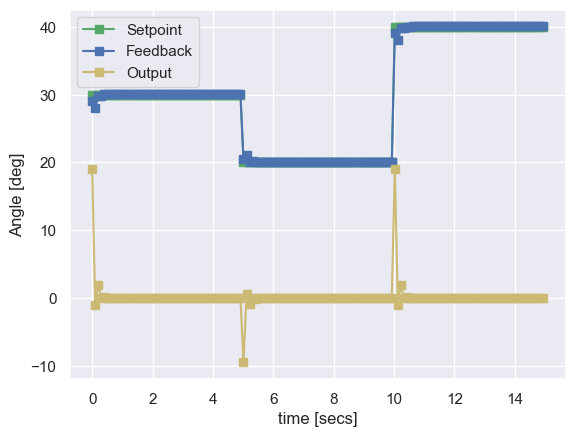

In [10]:
plt.figure()
plt.plot(t_arr, setpoint_arr, color='g', marker='s', label='Setpoint')
plt.plot(t_arr, feedback_arr, color='b', marker='s', label='Feedback')
plt.plot(t_arr, output_arr, color='y', marker='s', label='Output')
plt.ylabel("Temperature [℃]")
plt.xlabel("Time [secs]")
plt.legend()
plt.show()

Let's output RMSE plot and final value:

Final RMSE: 0.27862486184196084


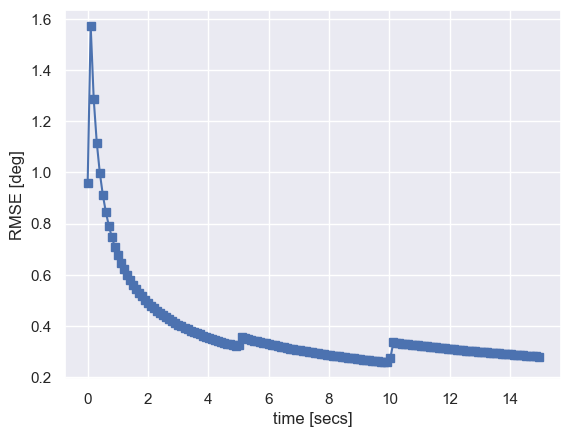

In [11]:
print("Final RMSE: {RMSE}".format(RMSE=rmse_arr[-1]))
plt.figure()
plt.plot(t_arr, rmse_arr, color='b', marker='s')
plt.ylabel("RMSE [deg]")
plt.xlabel("Time [secs]")
plt.show()